<a href="https://colab.research.google.com/github/tombrash/handson-ml2/blob/master/workbooks/ch15/rnn_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32)

In [23]:
n_steps=50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000,-1]
X_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

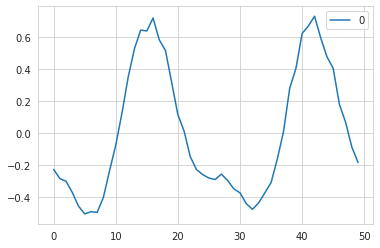

In [24]:
sns.set_style('whitegrid')
pd.DataFrame(X_train[0]).plot()

### Testing naive clasifier

Using the last value provided as the prediction

In [25]:
y_pred = X_val[:,-1]
np.mean(keras.losses.mean_squared_error(y_val, y_pred))

0.019943697

### Testing simple fully connected model

In [26]:
model = keras.models.Sequential([
                                 layers.Flatten(input_shape=[50,1]),
                                 layers.Dense(1)
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='nadam', loss='mean_squared_error')

In [30]:
model.fit(X_train, y_train, 
          batch_size=32, 
          epochs=50, 
          validation_data=(X_val, y_val), 
          callbacks = keras.callbacks.EarlyStopping(patience=3))

Epoch 1/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 2/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 3/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 4/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 5/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 6/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 7/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 9/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/50
219/219 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0036

In [31]:
fc_y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, fc_y_pred))

0.0032285133

### Trying a simple RNN

Using a single neuron RNN with arbitrary input shape to try and beat the fully connected neural network

In [45]:
model = keras.models.Sequential([
            layers.SimpleRNN(1, input_shape=[None,1])
])

In [46]:
model.compile(optimizer='nadam', loss='mse')

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.fit(X_train, 
          y_train,
          epochs=50,
          validation_data=(X_val, y_val),
          callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
219/219 [==============================] - 2s 9ms/step - loss: 0.0862 - val_loss: 0.0704
Epoch 2/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0623 - val_loss: 0.0510
Epoch 3/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0442 - val_loss: 0.0357
Epoch 4/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0303 - val_loss: 0.0244
Epoch 5/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0208 - val_loss: 0.0173
Epoch 6/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0154 - val_loss: 0.0137
Epoch 7/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 8/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 9/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 10/50
219/219 [==============================] - 2s 8ms/step - loss: 0.0115 - val_loss: 0.0114

In [49]:
rnn_y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, rnn_y_pred))

0.010989992

### More complicated RNN

Adding deeper layers and more neurons in each layer

In [50]:
model = keras.models.Sequential([
            layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
            layers.SimpleRNN(20),
            layers.Dense(1)
])

In [51]:
model.compile(optimizer='adam', loss='mse')

In [53]:
model.fit(X_train, y_train, 32, 30, validation_data=(X_val, y_val),
          callbacks=keras.callbacks.EarlyStopping(patience=3))

Epoch 1/30
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 2/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 4/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 6/30
219/219 [==============================] - 4s 16ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 9/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/30
219/219 [==============================] - 4s 17ms/step - loss: 0.0028 - val_lo

In [54]:
rnn_b_y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, rnn_b_y_pred))

0.0030992709

## Forecasting the next 10 values at the same time

In [56]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [60]:
model =keras.models.Sequential([
        layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
        layers.SimpleRNN(20),
        layers.Dense(10)
])

model.compile(optimizer='adam', loss='mse')

In [62]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=30,
          callbacks=keras.callbacks.EarlyStopping(patience=5),
          validation_data=(X_val, y_val))

Epoch 1/30
219/219 [==============================] - 4s 20ms/step - loss: 0.0602 - val_loss: 0.0355
Epoch 2/30
219/219 [==============================] - 4s 18ms/step - loss: 0.0278 - val_loss: 0.0204
Epoch 3/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0179 - val_loss: 0.0140
Epoch 4/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 5/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 6/30
219/219 [==============================] - 4s 20ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 7/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 8/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 9/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 10/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0099 - val_lo

In [64]:
rnn_c_y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, rnn_c_y_pred))

0.00918515

### Sequence to sequence model

The previous version predicts ten steps at a single time. However, it only makes a prediction on the next ten steps beyond the sequence. Better performance can be realized by outputing a prediction at every step, allowing more loss gradients to flow through the model

In [65]:
# create a new Y vector that has 10D vectors at each step

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1,10+1):
  Y[:,:, step_ahead-1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_val = Y[7000:9000]
Y_test = Y[9000:]

In [67]:
model = keras.models.Sequential([
          layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
          layers.SimpleRNN(20, return_sequences=True),
          layers.TimeDistributed(layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:, -1])

model.compile(optimizer='adam', loss='mse', metrics=[last_time_step_mse])


In [69]:
model.fit(X_train, Y_train,
          batch_size=32,
          epochs=30,
          validation_data=(X_val, Y_val),
          callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/30
219/219 [==============================] - 5s 24ms/step - loss: 0.0831 - last_time_step_mse: 0.0753 - val_loss: 0.0514 - val_last_time_step_mse: 0.0387
Epoch 2/30
219/219 [==============================] - 5s 23ms/step - loss: 0.0481 - last_time_step_mse: 0.0359 - val_loss: 0.0452 - val_last_time_step_mse: 0.0330
Epoch 3/30
219/219 [==============================] - 5s 21ms/step - loss: 0.0423 - last_time_step_mse: 0.0296 - val_loss: 0.0396 - val_last_time_step_mse: 0.0259
Epoch 4/30
219/219 [==============================] - 4s 18ms/step - loss: 0.0383 - last_time_step_mse: 0.0235 - val_loss: 0.0373 - val_last_time_step_mse: 0.0219
Epoch 5/30
219/219 [==============================] - 5s 21ms/step - loss: 0.0364 - last_time_step_mse: 0.0208 - val_loss: 0.0358 - val_last_time_step_mse: 0.0193
Epoch 6/30
219/219 [==============================] - 5s 23ms/step - loss: 0.0351 - last_time_step_mse: 0.0193 - val_loss: 0.0340 - val_last_time_step_mse: 0.0179
Epoch 7/30
219/219 [==